In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from tqdm import tqdm
import matplotlib

import calculation.MeanFieldv2 as MFv2
import calculation.CurrentMeirv2 as CsMv2
import calculation.SusceptibilitySimpv2 as Susceptv2

from matplotlib.colors import LinearSegmentedColormap
import settings.Constants as const

from matplotlib.colors import LinearSegmentedColormap
import settings.Constants as const


viridis_mod = LinearSegmentedColormap.from_list(
    "viridis_mod", plt.cm.viridis(np.linspace(0, 0.8, 256))
)



In [2]:
### Order Parameter and Mean-Field Current Calculation

### Parameters
Tvalue = 1e-6
couplingValue = 0.7
voltageValue = 0.0


couplingVec = np.array([couplingValue])


lambdaSpaceCenter = np.linspace(0.6, 2.5, 500)
lambdaSpaceRight = np.linspace(2.5, 100.0, 500)
lambdaSpaceLeft = np.linspace(0.1, 0.6, 10)

lambdaSpacePlot = np.unique(np.concatenate((lambdaSpaceLeft, lambdaSpaceCenter, lambdaSpaceRight)))


# lambdaSpacePlot = np.linspace(0.5, 100.0, size_vec)

colorsVoltage = viridis_mod(np.linspace(0, 0.85, 4))


## Initial Conditions
phiConstantInit = 0.5
phiLambdaInit = 0.9

In [3]:
phiMFSpace = np.zeros((couplingVec.shape[0], lambdaSpacePlot.shape[0]), dtype=float)

pbar = tqdm(total=couplingVec.shape[0]*lambdaSpacePlot.shape[0], desc='Computing phi(lambda)')

for j in range(couplingVec.shape[0]):
    couplingValue = couplingVec[j]
    for i in range(lambdaSpacePlot.shape[0]):
        lambdaValue = lambdaSpacePlot[i]
        result = scipy.optimize.root(MFv2.computeMFLambda, phiConstantInit, args=(lambdaValue, voltageValue, Tvalue, MFv2.Impy, couplingValue), method='lm', tol=1e-6)
        phiMFSpace[j,i] = result.x[0]
        
        pbar.update(1)

pbar.close()




Computing phi(lambda): 100%|██████████| 1008/1008 [00:17<00:00, 58.58it/s]


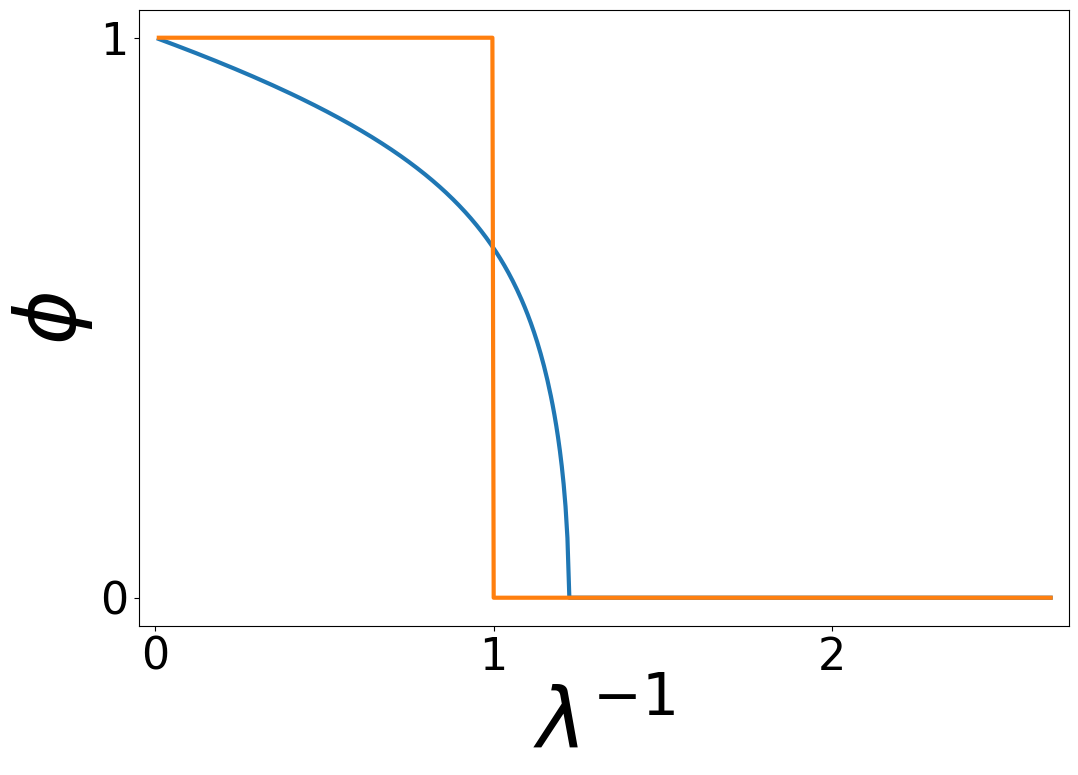

In [4]:

phiSpaceZeroGamma = np.zeros_like(lambdaSpacePlot)
mask = lambdaSpacePlot > 1.0
phiSpaceZeroGamma[mask] = 1.0

phiSpaceGamma = phiMFSpace[0,:]

phiSpaceGamma[np.reciprocal(lambdaSpacePlot) > 3.0] = np.nan
phiSpaceZeroGamma[np.reciprocal(lambdaSpacePlot) > 3.0] = np.nan


# Opti
fig, ax = plt.subplots(figsize=(12, 8))
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
ax.plot(np.reciprocal(lambdaSpacePlot), phiSpaceGamma, label=r'$\Gamma = 0.35 \Lambda$', linewidth=3.0)
ax.plot(np.reciprocal(lambdaSpacePlot), phiSpaceZeroGamma, label=r'$\Gamma = 0$', linewidth=3.0)
# plt.legend()

ax.set_xticks([0.0, 1.0, 2.0])
ax.set_yticks([0.0, 1.0])

ax.tick_params(axis='x', labelsize=32)
ax.tick_params(axis='y', labelsize=32)

# plt.title(r'$V=0 ~~~~~ T = 0$', fontsize=33)
# plt.grid()
plt.xlim(-0.05, 2.7)
plt.xlabel(r'$\lambda^{-1}$', fontsize=60)
plt.ylabel(r'$\phi$', fontsize=60)
plt.savefig('panels/phi_lambda_modelPanel.png', bbox_inches='tight', dpi=600)

In [10]:

phiValue = 0.0001
TSpacePlot = np.linspace(1e-5, 2.5, 100)

voltageSpacePlot = np.linspace(0.0, 2.5, 60)


boundary3D = np.zeros((len(voltageSpacePlot), len(TSpacePlot)))

pbar = tqdm(total=len(TSpacePlot)*len(voltageSpacePlot))
for j in range(len(voltageSpacePlot)):
    voltageValue = voltageSpacePlot[j]
    for i in range(len(TSpacePlot)):
        Tvalue = TSpacePlot[i]
        result = scipy.optimize.root(MFv2.computeMeanField, phiLambdaInit, args=(phiValue, voltageValue, Tvalue, MFv2.Impy, couplingValue), method='lm', tol=1e-6)
        boundary3D[j, i] = result.x
        pbar.update(1)


  0%|          | 0/6000 [00:00<?, ?it/s]/var/folders/l6/sz7h_28d1vn668qy7qlhpvzw0000gn/T/ipykernel_45142/3240250063.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  boundary3D[j, i] = result.x
100%|██████████| 6000/6000 [01:06<00:00, 91.35it/s] 

(100,)
(60,)
(60, 100)


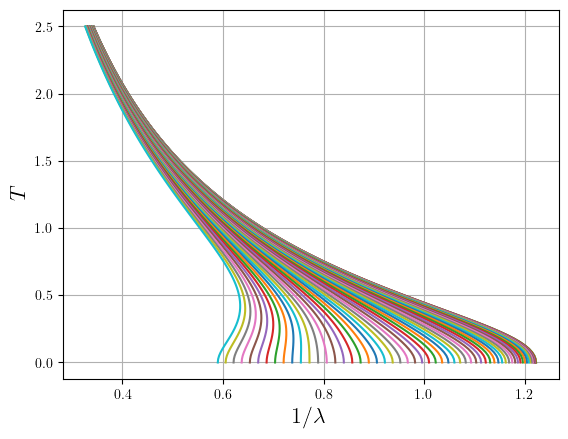

In [11]:
plt.figure()
for j in range(len(voltageSpacePlot)):
    plt.plot(np.reciprocal(boundary3D[j,:]), TSpacePlot)
    
plt.grid()

plt.ylabel(r'$T$', fontsize=16)
plt.xlabel(r'$1/\lambda$', fontsize=16)


print(TSpacePlot.shape)
print(voltageSpacePlot.shape)
print(boundary3D.shape)

Text(0.5, 0, '$1/\\lambda$')

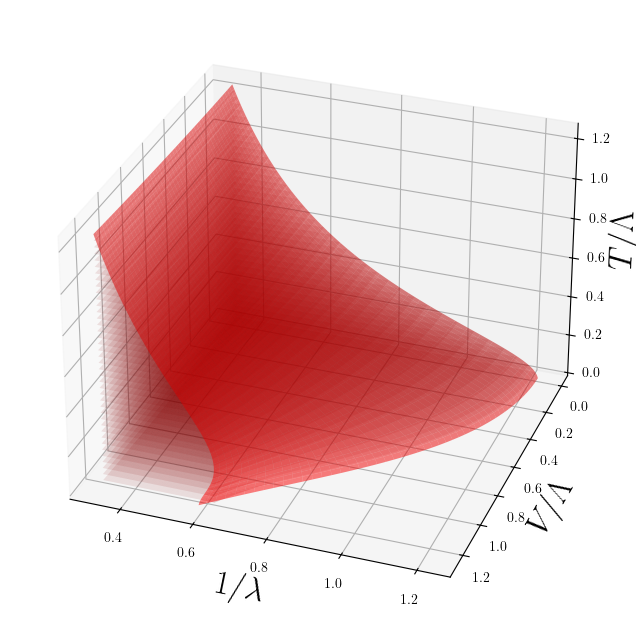

In [13]:
from scipy.interpolate import RegularGridInterpolator


interpolator = RegularGridInterpolator((voltageSpacePlot/2, TSpacePlot/2), np.reciprocal(boundary3D))

x_fine = np.linspace(1e-2, 1.25, 300)
y_fine = np.linspace(1e-2, 1.25, 300)
V_fine, T_fine = np.meshgrid(x_fine, y_fine, indexing='ij')

points_fine = np.array([V_fine.flatten(), T_fine.flatten()]).T
L_fine = interpolator(points_fine).reshape(V_fine.shape)


fig = plt.figure(figsize=(12, 8))
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=30, azim=110)

surf = ax.plot_surface(L_fine, V_fine, T_fine, color='red', alpha=0.5)

# Now fill the inside by stacking slices along z-axis
n_layers = 40
z_min = 0.04
z_max = np.max(T_fine)
z_slices = np.linspace(z_min, z_max, n_layers)

for z in z_slices:
    # For each z-slice, find where T_fine >= z and plot a contour line (as a filled area)
    mask = T_fine >= z
    x_layer = np.where(mask, L_fine, np.nan)
    y_layer = np.where(mask, V_fine, np.nan)
    z_layer = np.full_like(L_fine, z)

    ax.plot_surface(
        x_layer, y_layer, z_layer,
        color='red', alpha=0.1, edgecolor='none'
    )

xmin, xmax = ax.get_xlim()
ax.set_xlim(xmax, xmin)


ax.set_ylabel(r'$V/\Lambda$', fontsize=24)
ax.set_zlabel(r'$T/\Lambda$', fontsize=24)
ax.set_xlabel(r'$1/\lambda$', fontsize=24)


# fig.colorbar(surf, ax=ax, shrink=0.5, aspect=24)
# plt.tight_layout()
# plt.show()
# plt.savefig('figures/boundary_line_3D_modelPanel.png')


In [14]:
#### compute conductivity

lambdaValue = 1.0
Tspace = np.array([1e-5, 0.2, 0.8])

voltageSpace = np.linspace(0.0, 2.5, 300)


phiSpaceConductivity = np.zeros((len(Tspace), len(voltageSpace)))

pbar = tqdm(total=len(Tspace)*len(voltageSpace))

print(couplingValue)

for j in range(Tspace.shape[0]):
    for i in range(voltageSpace.shape[0]):
        voltageValue = voltageSpace[i]
        result = scipy.optimize.root(MFv2.computeMFLambda, phiConstantInit, args=(lambdaValue, voltageValue, Tspace[j], MFv2.Impy, couplingValue), method='lm', tol=1e-6)
        phiSpaceConductivity[j,i] = result.x[0]
        
        pbar.update(1)

pbar.close()

### compute current

currentSpace = np.zeros_like(phiSpaceConductivity)

for j in range(Tspace.shape[0]):
    for i in range(voltageSpace.shape[0]):
        currentSpace[j,i] = CsMv2.computeCurrent(lambdaValue, phiSpaceConductivity[j,i], voltageSpace[i], couplingValue, Tspace[j])


100%|██████████| 6000/6000 [02:37<00:00, 38.19it/s]


0.7


100%|██████████| 900/900 [00:35<00:00, 25.71it/s]


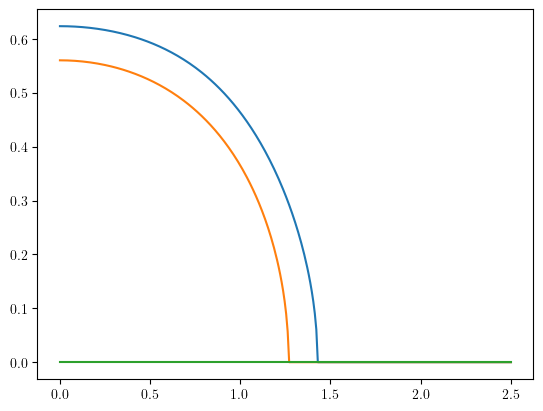

In [15]:
plt.plot(voltageSpace, phiSpaceConductivity[0,:])
plt.plot(voltageSpace, phiSpaceConductivity[1,:])
plt.plot(voltageSpace, phiSpaceConductivity[2,:])

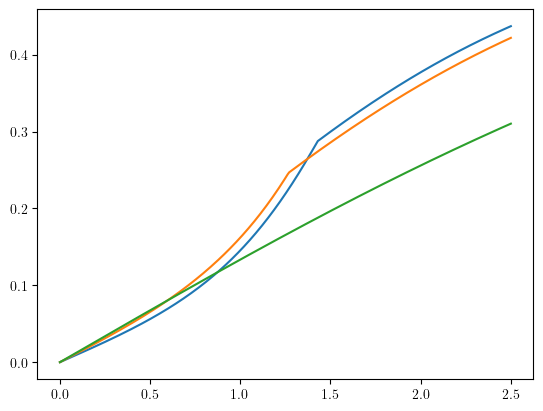

In [16]:
plt.plot(voltageSpace, currentSpace[0,:])
plt.plot(voltageSpace, currentSpace[1,:])
plt.plot(voltageSpace, currentSpace[2,:])

In [17]:
#### compute the derivative of the current

conductivityDerivative = np.zeros_like(phiSpaceConductivity)
conductivityDerivative2 = np.zeros_like(phiSpaceConductivity)

for j in range(Tspace.shape[0]):
    vec = currentSpace[j,:]
    dy_dx = np.zeros_like(vec)
    
    dy_dx[0] = (vec[1] - vec[0])/(voltageSpace[1] - voltageSpace[0])
    dy_dx[-1] = (vec[-1] - vec[-2])/(voltageSpace[-1] - voltageSpace[-2])
    dy_dx[1:-1] = (vec[2:] - vec[:-2])/(voltageSpace[2:] - voltageSpace[:-2])
    
    conductivityDerivative[j,:] = dy_dx
    
    conductivityDerivative2[j,:] = np.gradient(vec, voltageSpace, edge_order=2)
    


In [ ]:
# plt.plot(voltageSpace, conductivityDerivative[0,:])
# plt.plot(voltageSpace, conductivityDerivative[1,:])
# plt.plot(voltageSpace, conductivityDerivative[2,:])

1.4130434782608694
1.254180602006689


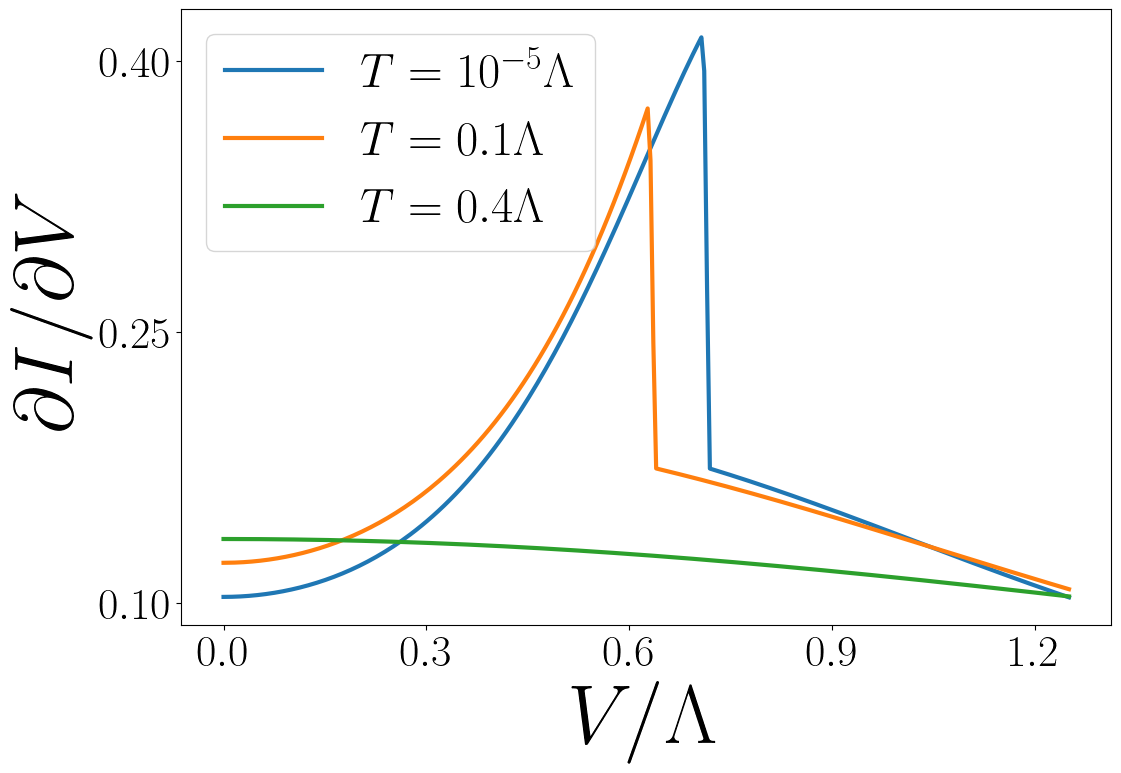

In [18]:
idx_max_zero = np.argmax(conductivityDerivative2[0,:])
idx_max_one = np.argmax(conductivityDerivative2[1,:])

# conductivityDerivative2[0, idx_max_zero+1] = np.nan
# conductivityDerivative2[0, idx_max_zero+2] = np.nan

# conductivityDerivative2[1, idx_max_one+1] = np.nan
# conductivityDerivative2[1, idx_max_one+2] = np.nan

print(voltageSpace[idx_max_zero])
print(voltageSpace[idx_max_one])

fig, ax = plt.subplots(figsize=(12, 8))
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
ax.plot(voltageSpace/2, conductivityDerivative2[0,:], linewidth=3.0, label=r'$T=10^{-5} \Lambda$')
ax.plot(voltageSpace/2, conductivityDerivative2[1,:], linewidth=3.0 , label=r'$T=0.1 \Lambda$')
ax.plot(voltageSpace/2, conductivityDerivative2[2,:], linewidth=3.0, label=r'$T=0.4 \Lambda$')

# ax.plot(voltageSpace/Tspace[0], conductivityDerivative2[0,:], linewidth=3.0, label=r'$T=10^{-5} \Lambda$')
# ax.plot(voltageSpace/Tspace[1], conductivityDerivative2[1,:], linewidth=3.0 , label=r'$T=0.1 \Lambda$')
# ax.plot(voltageSpace/Tspace[2], conductivityDerivative2[2,:], linewidth=3.0, label=r'$T=0.4 \Lambda$')


# ax.axvline(x=voltageSpace[idx_max_zero]/2, color='black', linestyle='dotted')
# ax.axvline(x=voltageSpace[idx_max_one]/2, color='black', linestyle='dotted')
ax.set_yticks([0.1, 0.25, 0.4])
ax.set_xticks([0.0, 0.3, 0.6, 0.9, 1.2])

ax.tick_params(axis='x', labelsize=32)
ax.tick_params(axis='y', labelsize=32)

plt.legend(fontsize=35, loc="upper left")


# plt.xscale('log')
# plt.yscale('log')
plt.xlabel(r'$V/\Lambda$', fontsize=60)
plt.ylabel(r'$\partial I/\partial V$', fontsize=60)

plt.savefig('panels/conductivity_modelPanel.png', bbox_inches='tight', dpi=600)
